In [7]:
# Load libraries needed to run the code.

library(tidyverse)
library(ggtern)
library(svglite)

# Load and prepare electricity generation data by Ember (https://ember-climate.org/app/uploads/2022/07/yearly_full_release_long_format-1.csv).

electricity_eu_countries <-  read_csv("../data/ember/yearly_full_release_long_format-1.csv",
                # Select only columns relevant for the analysis.          
                        col_select = c("Country code", "Year", "Category", "Variable", "Value", "Unit", "EU"),
                        show_col_types = FALSE) |>
                # Filter EU countries and UK, electricity generation category, and TWh unit.
                filter(EU == 1 | `Country code` == "GBR", Category %in% c("Electricity generation"),
                         Unit == "TWh") |>
                # Select only columns relevant for the plot, hence leave out Category, Unit, and EU columns.
                select(CountryCode = "Country code",
                       Year = "Year",
                       Variable = "Variable",
                       Value = "Value") |>
                # Add a new column based on energy source.
                mutate(ProdCategory = case_when(Variable %in% c("Coal", "Gas", "Other Fossil") ~ "Fossil",
                                                Variable %in% c("Wind", "Solar", "Hydro", "Bioenergy") ~ "Renewables",
                                                Variable == "Nuclear" ~ "Nuclear")) |>
                # Filter out NAs in ProdCategory column, omit Variable column.
                filter(ProdCategory != "NA") |>
                select(-Variable) |>
                # Group rows by CountryCode, Year and ProdCategory, while summarising Valuek column.
                group_by(CountryCode, Year, ProdCategory) |>
                summarise(Value = sum(Value),
                          .groups = "drop")


intro **čokýsek**

`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


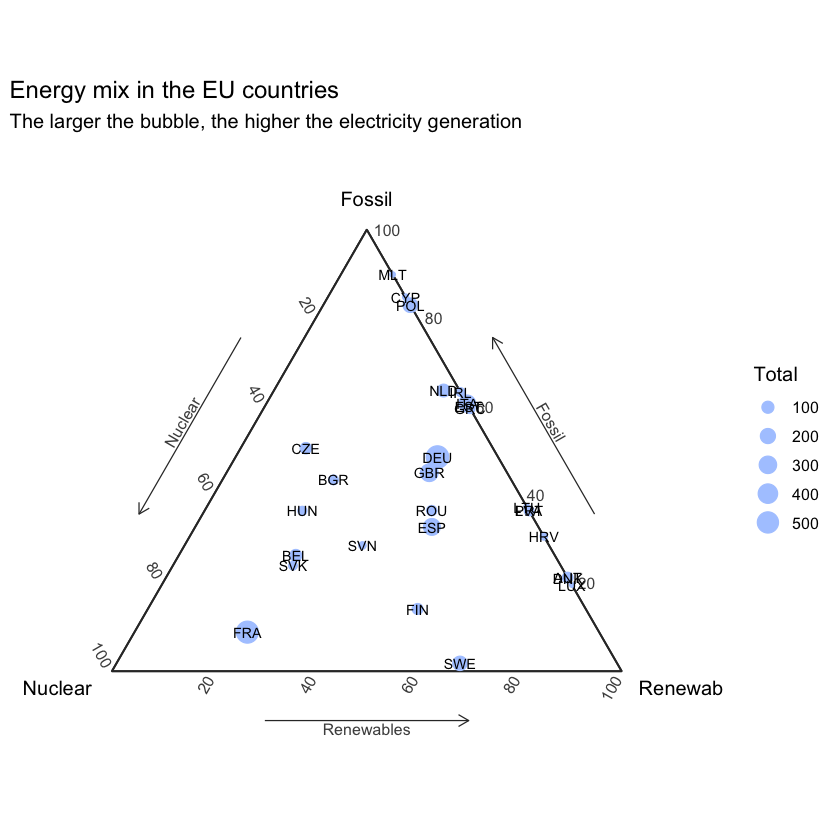

In [9]:
electricity_eu_total <- filter(electricity_eu_countries, CountryCode != "GBR") |>
  group_by(Year, ProdCategory) |>
  summarise(Value = sum(Value)) |>
  mutate(CountryCode = "EU27",
                   .before=Year)

electricity_eu <- rbind(electricity_eu_countries, electricity_eu_total)

# Calculate electricity shares.
electricity_shares <- electricity_eu |>
  group_by(CountryCode, Year) |>
  mutate(Total = sum(Value),
         Share = Value / Total) |>
  select(-Value) |>
  pivot_wider(names_from = ProdCategory, values_from = Share)

# Generate ternary plot as of 2021.

filter(electricity_shares, Year == 2021, CountryCode != "EU27") |>
  ggtern(aes(Nuclear, Fossil, Renewables)) +
  geom_point(aes(size = Total), colour = "#aecaff") +
  geom_text(aes(label = CountryCode), size = 3) +
  labs(x = "Nuclear",
       y = "Fossil",
       z = "Renewables",
       title = "Energy mixes in the EU countries",
       subtitle = "The larger the bubble, the higher the electricity generation") +
  theme_bw() +
  theme_nomask() +
  theme_showarrows()

# svglite::svglite("ternary-plot-eu.svg")
# dev.off()

# Generate ternary plot showing a path of a single country.

# filter(electricity_shares, CountryCode == "CZE") %>%
#   ggtern(aes(Nuclear, Fossil, Renewables)) +
#   geom_point(aes(colour = Year), size = 1) +
#   geom_path(aes(colour = Year)) +
#   labs(x = "Nuclear",
#        y = "Fossil",
#        z = "Renewables",
#        title = "Energy mix path in Czechia, 2000–2021") +
#   scale_colour_gradient("Rok") +
#   guides(colour = guide_colourbar(barheight = 8, barwidth = 0.5, title.position = "top")) +
#   theme_nomask() +
#   theme_bw() +
#   theme_showarrows()

# Generate small multiples of ternary plots for each country.
# electricity_shares %>%
#   ggtern(aes(Nuclear, Fossil, Renewables)) +
#   geom_point(aes(colour = Year), size = 1) +
#   geom_path(aes(colour = Year)) +
#   labs(x = "Jádro",
#        y = "Fosilní paliva",
#        z = "OZE",
#        title = "Vývoj podílu zdrojů na energetickém mixu v Dánsku") +
#   scale_colour_gradient("Rok") +
#   guides(colour = guide_colourbar(barheight = 8, barwidth = 0.5, title.position = "top")) +
#   facet_wrap(vars(CountryCode), ncol = 6) +
#   theme_nomask() +
#   theme_bw() +
#   theme_notitles() +
#   theme(text = element_blank())
